# Simultaneous generation-classification using LSTM 
Implementation of the paper: Simultaneous Generation-classification using lstm 

Authors: Daniel L. Marino, Kasun Amarasinghe, Milos Manic

This script implements the training using Generation and Classification as objective

In [1]:
#************************************************************************
#      __   __  _    _  _____   _____
#     /  | /  || |  | ||     \ /  ___|
#    /   |/   || |__| ||    _||  |  _
#   / /|   /| ||  __  || |\ \ |  |_| |
#  /_/ |_ / |_||_|  |_||_| \_\|______|
#    
#
#   Copyright (2016) Modern Heuristics Research Group (MHRG)
#   Virginia Commonwealth University (VCU), Richmond, VA
#   http://www.people.vcu.edu/~mmanic/
#   
#   This program is free software: you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation, either version 3 of the License, or
#   (at your option) any later version.
#
#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.
#  
#   Any opinions, findings, and conclusions or recommendations expressed 
#   in this material are those of the author's(s') and do not necessarily 
#   reflect the views of any other entity.
#  
#   ***********************************************************************


In [2]:
import os
import numpy as np
import random
import tensorflow as tf
import pickle
import math
import matplotlib.pyplot as plt
from six.moves import range
import time

from twodlearn.tf_lib.Feedforward import LinearLayer
from twodlearn.tf_lib.Recurrent import *

import sys
working_dir= os.getcwd()

print('Working directory:', working_dir)

Working directory: /home/marinodl/projects/co_generation_classification/sentiment_analysis_imdb


#### Configuration Variables

In [3]:
allow_gpu= False
allow_valid= True
allow_test= True
Valid_Percentage= 0.1 # i.e. 10% of the data will be used for validation

pos_net_name= '_pos'
neg_net_name= '_neg'

activation_function='tanh'
num_nodes = [100, 100] #num_nodes: Nodes for the LSTM cell
alpha = 10.0 #0.1 #0.1
beta = 0.1 #0.01 #10000.01
lambda_w = 0.00001

dropout_cons = 0.8

Allow_Bias= False 

learning_rate= 0.005      # 0.001
grad_clip_thresh= 1.1       # 0.00001

current_run= 1
batch_size= 64 #64
num_unrollings= 64 #100

batch_size_val= 64 #len(valid_text_pos)/num_unrollings_val #500
num_unrollings_val= num_unrollings #100

batch_size_test= 64 
num_unrollings_test= num_unrollings #100

comment='_noDropout_LcLpLcp_64unrol_standarloss'

In [4]:
model_version = 'L'+str(len(num_nodes))
print("num_nodes:",num_nodes)
print("alpha:",alpha, ", beta:",beta,", lambda_w:", lambda_w)
print("num_unrollings:",num_unrollings, ", batch_size:",batch_size,", batch_size_val:", batch_size_val)
print("learning_rate:", learning_rate, 'grad_clip_thresh:', grad_clip_thresh)

num_nodes: [100, 100]
alpha: 10.0 , beta: 0.1 , lambda_w: 1e-05
num_unrollings: 64 , batch_size: 64 , batch_size_val: 64
learning_rate: 0.005 grad_clip_thresh: 1.1


# 1. Load training dataset

In [5]:
vc= pickle.load( open( "imdb_vc.pkl", "rb" ) )
num_inputs=  vc.vocabulary_size
num_outputs= vc.vocabulary_size

dataset= pickle.load( open( "imdb_dataset.pkl", "rb" ) )

# set batch_size and number of unrolligns
dataset.train.set_batch_and_unrollings(batch_size, num_unrollings)
dataset.valid.set_batch_and_unrollings(batch_size_val, num_unrollings_val)
dataset.test.set_batch_and_unrollings(batch_size_test, num_unrollings_test)

# print a sample of the dataset
train_x, train_y= dataset.train.next_batch()
print(len(train_x))
print(train_y.shape)
print(train_x[0].shape)

print(vc.keys2text([np.argmax(train_x[i][0,:], 0) for i in range(len(train_x))]))
print(train_y[0])

print(vc.keys2text([np.argmax(train_x[i][50,:], 0) for i in range(len(train_x))]))
print(train_y[50])

valid_x, valid_y= dataset.valid.next_batch()

65
(64, 1)
(64, 4001)
lame werewolf suit with the function i mean it just plain hard to sit through not to mention the act is terribl and the soundtrack is dub badli pleas i know the cover is interest what look like a hand reach for a woman s bare ass but don t wast your time or money as you won t get either back revolut alway present 
[ 0.]
and skip over when she is rape by four we see onli the threat and then betti recov and surviv pick herself up in desert and put on the brave face of someon who refus to lie down and die although no nuditi is involv it s betti s special interest photo that eventu troubl when we go back to the court the opinion of 
[ 1.]


In [6]:
print('# inputs:',num_inputs)

print('pos train length:',dataset.train.batch_generators[0]._text_size )
print('neg train length:',dataset.train.batch_generators[1]._text_size )

print('pos valid length:',dataset.valid.batch_generators[0]._text_size )
print('neg valid length:',dataset.valid.batch_generators[1]._text_size )

print('pos test length:',dataset.test.batch_generators[0]._text_size )
print('neg test length:',dataset.test.batch_generators[1]._text_size )

# inputs: 4001
pos train length: 2467781
neg train length: 2467781
pos valid length: 274197
neg valid length: 274197
pos test length: 2686211
neg test length: 2686211


# 2. Auxiliary functions

In [7]:
def classification_error(predictions, labels):
    """ number of samples wrongly classified  """
    return np.sum( np.not_equal( np.greater(predictions, 0.5), 
                                 np.greater(labels, 0.5)) )/labels.shape[0]

def logprob(predictions, labels):
    """Log-probability of the true labels in a predicted batch."""
    predictions[predictions < 1e-10] = 1e-10 # this is to prevent that log() returns minus infinity
    return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
    """Sample one element from a distribution assumed to be an array of normalized
    probabilities.
    """
    r = random.uniform(0, 1)
    s = 0
    for i in range(len(distribution)):
        s += distribution[i]
        if s >= r:
            return i
    return len(distribution) - 1

def sample(prediction):
    """Turn a (column) prediction into 1-hot encoded samples."""
    p = np.zeros(shape=[1, vc.vocabulary_size], dtype=np.float)
    p[0, sample_distribution(prediction[0])] = 1.0
    return p

def random_distribution():
    """Generate a random column of probabilities."""
    b = np.random.uniform(0.0, 1.0, size=[1, vc.vocabulary_size])
    return b/np.sum(b, 1)[:,None]

# 3. Model for positive and negative reviews

In [8]:
class myLstmNet(LstmNet):
    def get_extra_inputs(self, i, h_list, state_list):
        #print('OK:', len(h_list))
        return i
    
    def evaluate_final_output(self, outputs_list, inputs_list, h_list ):
        ''' Calculates the final output of the neural network, usually it is just a linear transformation
            - outputs_list: list with the outputs from the last lstm cell
            - inputs_list: list of inputs to the network
            - h_list: list with all hidden outputs from all the cells
        '''
        all_hidden = list()
        
        for t in h_list: # go trough each time step
            all_hidden.append( tf.concat(1,t) )
        return self.out_layer.evaluate(tf.concat(0, all_hidden))  
            
    
if len(num_nodes)>1:
    n_extra= [num_inputs for i in range(len(num_nodes)+1)]
    n_extra[0]= 0
    n_extra[-1]= sum(num_nodes) - num_nodes[-1]
else:
    n_extra= [0,0]

In [9]:
class ModelSetup:
    
    def __init__( self, pos_net, neg_net, w, b, batch_size, num_unrollings, drop_prob_list, name=''):
    
        # 1. Create placeholders for inputs 
        self.X = list()
        for iaux in range(num_unrollings + 1):
            self.X.append(tf.placeholder(tf.float32, shape=[batch_size, vc.vocabulary_size], 
                                             name= name+'X_i'+str(iaux)+'_All'))
        aux_inputs = self.X[:num_unrollings]
        aux_labels = self.X[1:]  # inputs shifted by one time step.

        # Create a list for store the placeholders for the labels
        self.labels = tf.placeholder(tf.float32, shape=[batch_size, 1])
       

        # -------------------- unrolling of the network --------------------------- # 
        self.pos_unroll, _= pos_net.unrolling_setup( batch_size, num_unrollings, 
                                                     inputs_list= aux_inputs,
                                                     labels_list= aux_labels,
                                                     drop_prob_list= drop_prob_list,
                                                     reset_between_unrollings= True,
                                                   )

        self.neg_unroll, _= neg_net.unrolling_setup( batch_size, num_unrollings, 
                                                     inputs_list= aux_inputs,
                                                     labels_list= aux_labels,
                                                     drop_prob_list= drop_prob_list,
                                                     reset_between_unrollings= True,
                                                   ) 


        # Classifier.
        # error_per_sample is a vector, its shape is changed to have each unrolling in separate columns
        output_pos= tf.reshape(self.pos_unroll.error_per_sample,[num_unrollings,batch_size])  
        output_neg= tf.reshape(self.neg_unroll.error_per_sample,[num_unrollings,batch_size]) 

        output_pos_mean= tf.reduce_mean(output_pos, reduction_indices= 0) 
        output_neg_mean= tf.reduce_mean(output_neg, reduction_indices= 0) 

        output_mean= tf.transpose(tf.pack( [ output_pos_mean, output_neg_mean ]))


        self.logits = tf.nn.xw_plus_b( output_mean , w, b )


        self.error_per_sample= tf.nn.sigmoid_cross_entropy_with_logits( self.logits, self.labels )
        
        # prediction error
        #Lp = tf.reduce_mean( tf.mul(self.labels, output_pos_mean) + tf.mul(self.labels-1, output_neg_mean))
        Lp = tf.reduce_mean( tf.mul(tf.squeeze(self.labels), output_pos_mean) + 
                             tf.mul(tf.squeeze(1-self.labels), output_neg_mean)
                           )
        # c-p penalty
        Lcp = tf.reduce_mean( tf.mul(tf.squeeze(1-self.labels), tf.exp(-output_pos_mean)) + 
                              tf.mul(tf.squeeze(self.labels), tf.exp(-output_neg_mean))
                            )
        
        #Lcp = tf.reduce_mean( tf.mul(tf.squeeze(1-self.labels), tf.reduce_mean(tf.exp(-output_pos), reduction_indices= 0) ) + 
        #                      tf.mul(tf.squeeze(self.labels), tf.reduce_mean(tf.exp(-output_neg), reduction_indices= 0) )
        #                    )
        
        # regularization
        l2_c= tf.nn.l2_loss(w)
        
        # loss
        #self.loss = tf.reduce_mean( self.error_per_sample ) + alpha*Lp + beta*(1.0/Lcp)
        #self.loss = tf.reduce_mean( self.error_per_sample ) + alpha*Lp - beta*(Lcp)
        self.alpha_r = tf.placeholder(tf.float32)
        self.beta_r = tf.placeholder(tf.float32)
        
        self.loss = tf.reduce_mean( self.error_per_sample ) + self.alpha_r*Lp + self.beta_r*Lcp + lambda_w*l2_c
        
        # classification error
        self.error = tf.reduce_mean( tf.to_float(tf.not_equal( tf.greater(tf.nn.sigmoid(self.logits), 0.5), 
                                                               tf.greater(self.labels, 0.5))) )
        
        # perplexity measure
        next_words_prob_pos = -tf.log( tf.nn.softmax( self.pos_unroll.y ) + 1e-10)
        next_words_prob_neg = -tf.log( tf.nn.softmax( self.neg_unroll.y ) + 1e-10)
            
        next_words=  tf.concat(0,aux_labels) 
        
        logprob_pos= tf.reshape( tf.reduce_sum( next_words_prob_pos * next_words, 1), [batch_size, num_unrollings] )
        logprob_neg= tf.reshape( tf.reduce_sum( next_words_prob_neg * next_words, 1), [batch_size, num_unrollings] )  
               
        #self.perplexity_pos( -tf.log( prob_pos + 1e-10 ) * self.labels )
        #self.perplexity_neg( -tf.log( prob_neg + 1e-10 ) * (1-self.labels) )
        self.perplexity_pos = tf.reduce_sum( logprob_pos * self.labels )/(batch_size/2.0) 
        self.perplexity_neg = tf.reduce_sum( logprob_neg * (1-self.labels) )/(batch_size/2.0) 

In [10]:

graph = tf.Graph()
with graph.as_default():
    # For dropout
    drop_prob = tf.placeholder(tf.float32)
    drop_prob_list = [ drop_prob for i in range(len(num_nodes)+1)]
    drop_prob_list[0]= None
     
    # 1. Define positive and negative neural networks
    pos_net= myLstmNet( num_inputs, num_nodes, num_outputs, n_extra= n_extra,
                        afunction=activation_function, 
                        LstmCell= AlexLstmCell,
                        name= pos_net_name)
        
    neg_net= myLstmNet( num_inputs, num_nodes, num_outputs, n_extra= n_extra,
                        afunction=activation_function, 
                        LstmCell= AlexLstmCell,
                        name= neg_net_name)
    
    # Classifier weights and biases.
    #w = tf.Variable(tf.truncated_normal([2, 1], -0.1, 0.1), name=('w_class')) # unconstrained w
    #w = tf.Variable(tf.constant( [[-2.0], [2.0]]), name=('w_class'), trainable=False) # fixed w
    
    #w = tf.Variable(tf.truncated_normal([1, 1], 0.3, 0.4), name=('w_class')) # unconstrained w
    w = tf.Variable(tf.constant( [[0.3]] ), name=('w_class')) # fixed w
    w = tf.concat(0, [-w, w])
    
    b = tf.Variable(tf.zeros([1]), name=('b_class'), trainable=Allow_Bias)
    
    
    
    # 2. Define unrolling for training
    train= ModelSetup( pos_net, neg_net, w, b, batch_size, num_unrollings, 
                       drop_prob_list, 
                       name='train_')
       
    # 3. Define unrolling for validation
    if allow_valid:
        valid= ModelSetup( pos_net, neg_net, w, b, batch_size_val, num_unrollings_val, 
                           drop_prob_list= [None for dummy in range(len(num_nodes))], 
                           name='valid_')
        
    # 4. Define unrolling for testing
    if allow_test:
        test= ModelSetup( pos_net, neg_net, w, b, batch_size_test, num_unrollings_test, 
                          drop_prob_list= [None for dummy in range(len(num_nodes))], 
                          name='test_')
    
    # 5. Define unrolling for testing generator
    pos_gen_test, _= pos_net.unrolling_setup( 1, 1, drop_prob_list= [None, None, None, None, None] )
    neg_gen_test, _= neg_net.unrolling_setup( 1, 1, drop_prob_list= [None, None, None, None, None] )
    
          
    
    # 6. Define optimizer    
    # 1. specify the optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate) # ADAM 0.001
    
    # 2. get the gradients and variables
    # grads_and_vars is a list of tuples (gradient, variable). 
    grads_and_vars = optimizer.compute_gradients(train.loss) 
    gradients, v = zip(*grads_and_vars)
    
    # 3. process the gradients
    gradients, _ = tf.clip_by_global_norm(gradients, grad_clip_thresh)  #1.25 #0.025 #0.001(last used)
    # 4. apply the gradients to the optimization procedure
    optimizer = optimizer.apply_gradients( zip(gradients, v) ) # ADAM
    
    # for prediction
    train_pred = tf.nn.sigmoid(train.logits)
    
    # Saver
    saver = tf.train.Saver()

# 4. Train Energy predictor model

In [11]:
reload_pos= False
load_pos_file=  working_dir+"/weights/Weights_LSTM_" + model_version +"_"+ str(num_nodes[0]) + "u_"+ \
                "1r_pos.ckpt"
    
reload_neg= False
load_neg_file= working_dir+"/weights/Weights_LSTM_" + model_version +"_"+ str(num_nodes[0]) + "u_"+ \
                "1r_neg.ckpt"

reload_all= True
load_all_file=  working_dir+"/weights/Weights_LSTM_" + model_version +"_"+ str(num_nodes[0]) + "u_"+ \
                str(current_run-1) +"r_All"+comment+".ckpt";

save_all= False
save_all_file=  working_dir+"/weights/Weights_LSTM_" + model_version +"_"+ str(num_nodes[0]) + "u_"+ \
                str(current_run) +"r_All"+comment+".ckpt";

In [12]:
if current_run==1:
    reload_all= False;
else:
    reload_pos= False;
    reload_neg= False;

In [13]:
num_steps = 6000 
summary_frequency = 50
n_valid_tests = 50
n_characters_step= num_unrollings*batch_size

train_error_l= list()
valid_error_l= list()

if allow_gpu:
    config= None
else:
    config = tf.ConfigProto( device_count = {'GPU': 0} )

aux_print=0
with tf.Session(graph=graph, config=config) as session:
    # -------------------------------- Load weigths from file, or initialize variables ------------------------------------
    if reload_all:
        saver.restore(session, load_all_file)
        #session.run( global_step.assign(0) ) # SGD
        
    elif (reload_pos and reload_neg):
        tf.initialize_all_variables().run()
        pos_net.saver.restore(session, load_pos_file)
        neg_net.saver.restore(session, load_neg_file)
        print('Weights for positive and negative networks loaded')
    else:
        tf.initialize_all_variables().run()
        print('Weights Initialized')
    
    # ------------------------------------------- Training loop --------------------------------------------------
    print('step | Train_err | Valid_err | loss')
    
    mean_loss = 0.0
    mean_error = 0.0
    
    start_time = time.time()
    
    for step in range(num_steps):
        # 1. Get next batch
        batch_X, batch_y = dataset.train.next_batch()
        
        # 2. Setup feed dictionary for network 1 and network 2
        feed_dict = dict()
        # For dropout
        feed_dict[drop_prob] = dropout_cons
        # hyperparameters
        feed_dict[train.alpha_r] = alpha
        feed_dict[train.beta_r] = beta
            
        # Inroduce labels
        feed_dict[train.labels] = batch_y
        # Introduce inputs
        for i in range(num_unrollings+1):
            feed_dict[train.X[i]] = batch_X[i]
              
        # 3 Run optimizer
        #_, l, lr = session.run( [optimizer, loss_train, learning_rate], feed_dict=feed_dict) # SGD
        _, l, train_error = session.run( [optimizer, train.loss, train.error], feed_dict=feed_dict) # ADAM
        
        mean_loss += l
        mean_error += train_error #classification_error(pred_train_aux, batch_y) 
        
        # --------------------------------------------- logging ------------------------------------------------
        if dataset.train.batch_generators[0]._text_size<aux_print :
            print('+'*80)
            print('')
            aux_print = 0
        else:
            aux_print += n_characters_step
        
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
                mean_error = mean_error / summary_frequency
                        
            # ---------- Print loss in validation dataset ---------
            if allow_valid:
                ''' classification error on validation dataset '''
                mean_error_val = 0.0
                for step_valid in range(n_valid_tests):
                    # 1. Get next batch
                    batch_X_val, batch_y_val = dataset.valid.next_batch()        
                    feed_dict_val = dict()
                    # For dropout
                    feed_dict_val[drop_prob] = 1.0
                    # Inroduce labels
                    feed_dict_val[valid.labels] = batch_y_val
                    # Introduce inputs
                    for i in range(num_unrollings_val+1):
                        feed_dict_val[valid.X[i]] = batch_X_val[i]
                    # 2. Get classification error
                    [valid_error] = session.run( [valid.error], feed_dict=feed_dict_val)          
                    mean_error_val += valid_error
                    
                mean_error_val = mean_error_val/n_valid_tests
                
                ''' print information '''
                train_error_l.append(mean_error)
                valid_error_l.append(mean_error_val)
                
                if save_all and valid_error_l[-1] == min(valid_error_l) and step>200:
                    save_path = saver.save(session, save_all_file)
                    print('%d | %f | %f | %f | saved' % (step, 
                                                         mean_error, 
                                                         mean_error_val, 
                                                         mean_loss
                                                        ))    
                
                else:
                    cur_time = time.time() - start_time
                    print('%d | %f | %f | %f | %f' % (step, 
                                                      mean_error, 
                                                      mean_error_val, 
                                                      mean_loss,
                                                      cur_time
                                                 ))   
                    
                #if(mean_error_val < 0.19):
                #    break
            else:
                train_error_l.append(mean_error)
                print('%d | %f | %f' % (step, mean_error, mean_loss))
                                       
            mean_loss = 0
            mean_error = 0
            
    if save_all and allow_valid:
        print("Learning finished, weights saved in file: %s" % save_path)
    

Weights Initialized
step | Train_err | Valid_err | loss
0 | 0.437500 | 0.495937 | 83.809677 | 27.665865
50 | 0.350938 | 0.355000 | 68.584866 | 117.532119
100 | 0.233750 | 0.307812 | 62.821073 | 207.062450
150 | 0.297812 | 0.355625 | 60.422969 | 296.371388
200 | 0.232187 | 0.285000 | 57.596723 | 385.681579
250 | 0.231250 | 0.256563 | 56.724815 | 474.956008
300 | 0.209687 | 0.255937 | 55.683403 | 564.298408
350 | 0.205937 | 0.271562 | 54.767180 | 653.472715
400 | 0.217500 | 0.262813 | 54.455047 | 742.875602
450 | 0.220000 | 0.262188 | 53.846041 | 833.204787
500 | 0.194375 | 0.261562 | 53.410270 | 922.962594
550 | 0.193125 | 0.248750 | 53.107418 | 1012.564749
600 | 0.199375 | 0.243125 | 52.838197 | 1102.210543
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

650 | 0.186875 | 0.235313 | 52.355610 | 1192.027143
700 | 0.187812 | 0.241875 | 52.810201 | 1280.932535
750 | 0.193125 | 0.232813 | 52.185216 | 1370.462742
800 | 0.180312 | 0.229687 | 51.955879 | 1459.

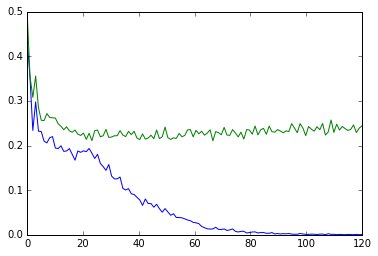

In [14]:
%matplotlib inline

train_error_a = np.array(train_error_l)
valid_error_a = np.array(valid_error_l)

plt.plot(np.linspace(0, train_error_a.shape[0], train_error_a.shape[0]) , train_error_a )
plt.plot(np.linspace(0, valid_error_a.shape[0], train_error_a.shape[0]) , valid_error_a )

### classification error on test dataset

In [15]:
n_tests = 600
if allow_test:
    with tf.Session(graph=graph) as session:
        # Load weigths from file, or initialize variables
        tf.initialize_all_variables().run()
        saver.restore(session, save_all_file)
        print('Weights loaded')
        
        # calculate errors using mini-batches
        mean_error_test = 0
        mean_perp_pos = 0
        mean_perp_neg = 0
        for step_test in range(n_tests):
            # 1. Get next batch
            batch_X_test, batch_y_test = dataset.test.next_batch()        
            feed_dict_test = dict()
            # For dropout
            feed_dict_test[drop_prob] = 1.0
            # Inroduce labels
            feed_dict_test[test.labels] = batch_y_test
            # Introduce inputs
            for i in range(num_unrollings_test+1):
                feed_dict_test[test.X[i]] = batch_X_test[i]
            # 2. Get prediction
            [test_error, perp_pos, perp_neg] = session.run( [test.error, test.perplexity_pos, test.perplexity_neg], 
                                                            feed_dict=feed_dict_test)          
            mean_error_test += test_error
            mean_perp_pos += perp_pos
            mean_perp_neg += perp_neg
            
        print("Classification error on test dataset:", mean_error_test)
        print("Perplexity on positive dataset:", mean_perp_pos)
        print("Perplexity on negative dataset:", mean_perp_neg)
        

NotFoundError: /home/marinodl/projects/co_generation_classification/sentiment_analysis_imdb/weights

## Generate some samples from positive and negative networks

In [ ]:
with tf.Session(graph=graph) as session:
    # Load weigths from file, or initialize variables
    tf.initialize_all_variables().run()
    saver.restore(session, save_all_file)
    print('Weights loaded')
        
    # print values for b and w
    b_t= b.eval()
    w_t= w.eval()
    #b_t= session.run(b)
    print('b=', b_t)
    print('w=', w_t)
    
    
    # For positive network
    print('a' + '-'*30 + 'pos' + '-'*30)
    for _ in range(5):
        feed = sample(random_distribution())
        sentence = vc.prob2char(feed)
        pos_gen_test.reset_saved_out_state.run()
        for _ in range(30):
            prediction = tf.nn.softmax(pos_gen_test.y).eval({pos_gen_test.inputs_list[0]: feed}) # feed is a 1-hot encoding
            feed = sample(prediction)  # sample returns a 1-hot encoding
            sentence += vc.prob2char(feed)
        print(sentence)
    print('a' + '-' * 80)
    
    # For negative network
    print('a' + '-'*30 + 'neg' + '-'*30)
    for _ in range(5):
        feed = sample(random_distribution())
        sentence = vc.prob2char(feed)
        neg_gen_test.reset_saved_out_state.run()
        for _ in range(30):
            prediction = tf.nn.softmax(neg_gen_test.y).eval({neg_gen_test.inputs_list[0]: feed}) # feed is a 1-hot encoding
            feed = sample(prediction)  # sample returns a 1-hot encoding
            sentence += vc.prob2char(feed)
        print(sentence)
    print('a' + '-' * 80)